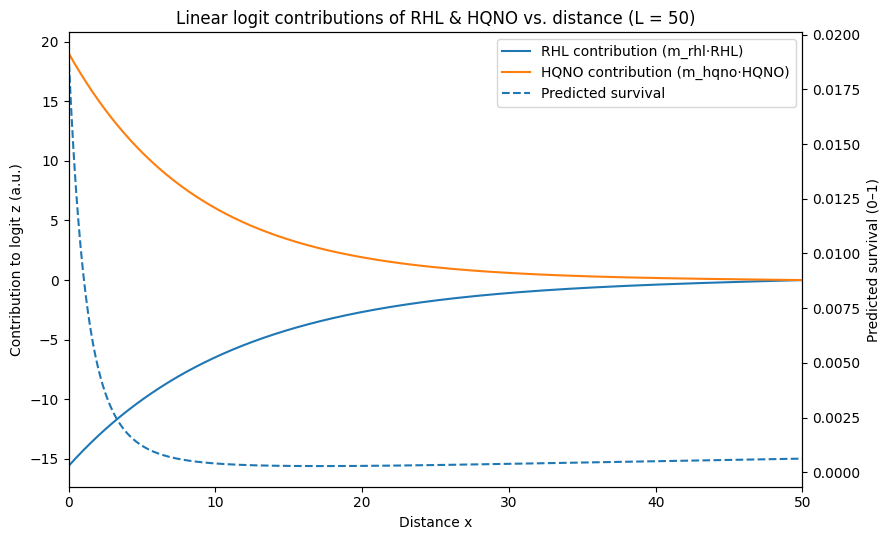

Saved figure to 3H_linear_hqno_rhl_survival_plot_contrib.png


In [ ]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Choose scenario parameters ----------
L = 50.0
x = np.linspace(0.0, L, 600)

# RHL starts high at x=0 and decays toward 0 at x=L
c_max_rhl   = 36.577317 # from SUPP_3F_fit_meta_analysis
A_rhl       = 0.007723 # conversion from bins to μm
offset_rhl  = 0.0

# HQNO starts modest and decays toward 0
c_max_hqno  = 0.092     # from SUPP_3C_fit_meta_analysis
A_hqno      = 0.013209  / 3 * 5 # conversion from bins to μm
offset_hqno = 0.0

# ---------- Helpers ----------
def theoretical_uptake_diffusion_solution(x, c_max, L, A, offset):
    """
    Theoretical uptake-diffusion profile:
    c(x) = -c_max * (e^{-sqrt(A)*(x-L)} - e^{+sqrt(A)*(x-L)}) / (e^{-sqrt(A)*L} - e^{+sqrt(A)*L}) + offset
    """
    sA = np.sqrt(A)
    numerator = -c_max * (np.exp(-sA*(x - L)) - np.exp(sA*(x - L)))
    denom = np.exp(-sA*L) - np.exp(sA*L)
    return numerator / denom + offset

def inv_logit(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

# ---------- Load model params from the LINEAR JSON ----------
# Expecting keys: parameters -> { "m_rhl", "m_hqno", "b" }
json_path = Path(r"C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3G_batch_survival\3G_Linear_RHL_HQNO_Logit_Model_params.json")
with open(json_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

m_rhl  = cfg["parameters"]["m_rhl"]
m_hqno = cfg["parameters"]["m_hqno"]
b      = cfg["parameters"]["b"]

# ---------- Compute fields ----------
rhl  = theoretical_uptake_diffusion_solution(x, c_max_rhl,  L, A_rhl,  offset_rhl)
hqno = theoretical_uptake_diffusion_solution(x, c_max_hqno, L, A_hqno, offset_hqno)

# Contributions used to predict survival (logit units) — now linear in both
rhl_contrib  = m_rhl  * rhl
hqno_contrib = m_hqno * hqno

# Linear predictor and survival
z = rhl_contrib + hqno_contrib + b
survival = inv_logit(z)

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(9, 5.5))

# Plot the coefficient-weighted signals
line1, = ax1.plot(x, rhl_contrib,  label="RHL contribution (m_rhl·RHL)")
line2, = ax1.plot(x, hqno_contrib, label="HQNO contribution (m_hqno·HQNO)")

ax1.set_xlabel("Distance x")
ax1.set_ylabel("Contribution to logit z (a.u.)")
ax1.set_xlim(0, L)

# Survival on twin axis
ax2 = ax1.twinx()
line3, = ax2.plot(x, survival, linestyle="--", label="Predicted survival")
ax2.set_ylabel("Predicted survival (0–1)")
#ax2.set_ylim(0, 1)

# Combined legend
lines = [line1, line2, line3]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper right")

ax1.set_title(f"Linear logit contributions of RHL & HQNO vs. distance (L = {L:g})")
plt.tight_layout()

out_path = "3H_linear_hqno_rhl_survival_plot_contrib.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure to {out_path}")
